# Medical Image Classification Using the MedNIST Dataset

## Introduction

Due to cost, privacy restrictions, and the rarity of certain conditions, gathering medical datasets can be particularly challenging. Once gathered from disparate sources, these data will need to be standardized for training. Preparing data at this level is beyond the scope of this short introductory primer.  
This MedNIST dataset was gathered from several sets at TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset.  

## Outline
<ul>
    <li>Create a dataset for training and testing</li>
    <li>Use MONAI transforms to pre-process data</li>
    <li>Use the DenseNet from MONAI for classification</li>
    <li>Train the model</li>
    <li>Test on new images</li>
</ul>


In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import monai.transforms.compose as compose
from monai.transforms import LoadPNG, AddChannel, Rescale, ToTensor
from monai.networks.nets.densenet import densenet121
import torch
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(551)

## Loading Data and Creating Datasets
The code below examines our image set, organizes the filenames, and displays some statistics about them.

In [2]:
dataDir = '/workspace/data/medical/MedNIST/resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Label names: ['Hand', 'AbdomenCT', 'CXR', 'ChestCT', 'BreastMRI', 'HeadCT']
Label counts: [10000, 10000, 10000, 10000, 8954, 10000]
Image dimensions: 64 x 64


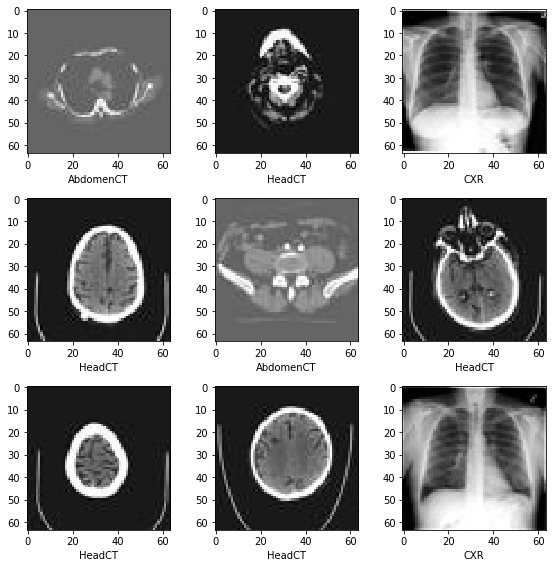

In [3]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      # plot and label them
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

## Use MONAI transforms to pre-process data

In [4]:
# Define transforms
transforms = compose.Compose([
    LoadPNG(),
    AddChannel(),
    Rescale(),
    ToTensor()
])

In [5]:
imageTensor = torch.stack([transforms(x) for x in imageFilesList])
classTensor = torch.tensor(imageClass)
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = 0.0; Max = 1.0; Mean = 0.244


## Prepare training, validation and test data lists
The code below will randomly assign approximately 10% of the indices to lists corresponding to the validation and testing sets. Once this is done, we can create these datasets by slicing the master image and label tensors using these lists.

In [6]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)

Training images = 47381 Validation = 5833 Testing = 5740


In [7]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    # training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

## Define network and optimizer
The learning rate reflects how much the model is updated per batch. If it is too small, the training proceeds slowly. If it's too large, the weights will be adjusted too much and miss the true minimum loss, or even become unstable. An epoch is a full run through the training data. Some models require thousands of epochs to train; this one will produce high accuracy with just a handful.

In [8]:
# Create DenseNet121 and Adam optimizer
device = torch.device("cuda:0")
model = densenet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=numClass
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
maxEpochs = 20            # Maximum training epochs

## Model training
We use validation data to prevent overtraining in our model. The training and validation data are drawn from the same set of data; therefore, the model ought to have similar loss for both. Thus, we set a limit on how much larger the validation loss can be than the training loss. Because random fluctuation might account for some discrepancy, we require a few epochs pass with high validation loss before halting.

The memory overhead required to feed large datasets through the model can be prohibitive. <em>Batches</em> are an important workaround for this problem. By loading smaller data subsets onto the GPU and training off of them, we can not only save memory, but also speed up the training by making more adjustments to the model per epoch. Smaller batches generally require smaller learning rates to avoid instability, however, so there is some tradeoff.

Imagine that a dataset had only a handful of examples of a particular label. The model could still acheive high accuracy overall while totally ignoring these. Using weights in the loss function, with larger weights for less numerous classes, is one strategy to combat this. If a class is particularly tiny, however, it is preferable to use data augmentation to generate new images rather than using weights alone, which are equivalent to feeding the same image over and over again through the network.

Now, we move on to the actual training loop. The first real step is to shuffle the data before slicing it into batches. Once again, PyTorch provides a <a href="https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader">DataLoader</a> class that can automate this, but it's about the same difficulty in this example to implement by hand.

Next, we iterate through the batches. We zero out the accumulated information in the optimizer, feed the batch through the model, and compute the loss for a batch. We use the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross entropy</a>, a common metric for classifiers. This loss is added to a running total for the epoch, and then we <em>backpropagate</em> it. Backpropagation is a mathematical determination of how much each weight in the model should be changed relative to the others to reduce the loss. The optimizer then takes a step and updates the weights.

After all the training batches are complete, the same process happens for the validation data, without the backpropagation and optimization steps. The average loss is calculated, and we compare the validation loss relative to the training loss to test for overfitting.

In [9]:
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(device)  # The weights average to 1

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        optimizer.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(device)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(device)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        optimizer.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(device)
            batY = validY[j*batchSize:(j+1)*batchSize].to(device)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

Epoch =   0; Training loss = 0.7110; Validation loss = 0.2052
Epoch =   1; Training loss = 0.1287; Validation loss = 0.0731
Epoch =   2; Training loss = 0.0586; Validation loss = 0.0400
Epoch =   3; Training loss = 0.0348; Validation loss = 0.0247
Epoch =   4; Training loss = 0.0232; Validation loss = 0.0171
Epoch =   5; Training loss = 0.0167; Validation loss = 0.0123
Epoch =   6; Training loss = 0.0124; Validation loss = 0.0093
Epoch =   7; Training loss = 0.0090; Validation loss = 0.0072
Epoch =   8; Training loss = 0.0071; Validation loss = 0.0059
Epoch =   9; Training loss = 0.0059; Validation loss = 0.0048
Epoch =  10; Training loss = 0.0046; Validation loss = 0.0043
Epoch =  11; Training loss = 0.0037; Validation loss = 0.0034
Epoch =  12; Training loss = 0.0032; Validation loss = 0.0033
Epoch =  13; Training loss = 0.0025; Validation loss = 0.0027
Epoch =  14; Training loss = 0.0023; Validation loss = 0.0023
Epoch =  15; Training loss = 0.0018; Validation loss = 0.0022
Epoch = 

## Testing the Model on New Data
With the model fully trained, it's time to apply it to generate predictions from the test dataset. The model outputs a 6 element vector for each image. The individual values of this vector can be thought of, roughly, as relative probabilities that the image belongs in each class. Thus, we consider the class with the maximum value to be the prediction of the model.

We'll use these predictions to generate a confusion matrix. Despite its name, the confusion matrix is easily understood. The rows in the matrix represent the correct classifications, while the columns represent the predictions of the model. When the row and the column agree (i.e., along the diagonal), the model predicted correctly.

In [10]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(device)
        batY = testY[j*batchSize:(j+1)*batchSize].to(device)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)

Correct predictions:  5736 of 5740
Confusion Matrix:
[[ 971    0    1    0    0    0]
 [   0 1003    0    0    0    0]
 [   2    0  983    0    0    0]
 [   0    0    0  959    0    0]
 [   0    0    0    0  845    0]
 [   0    1    0    0    0  975]]
['Hand', 'AbdomenCT', 'CXR', 'ChestCT', 'BreastMRI', 'HeadCT']
